In [1]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
import sys
import random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pylab as pl
from IPython import display
from numba import jit
from matplotlib import cm

In [2]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [3]:
class State(enum.IntEnum):
    ORIGIN = 0   #author    #orange
    RECEIVED = 1   #lightblue
    NOT_RECEIVED = 2
    SPREADER = 3
    DISINTERESTED = 4

In [4]:
min_max_norm = lambda x: np.round((x-x.min())/(x.max() - x.min()), 3)
mean_norm = lambda x: np.round((x-x.mean())/(x.max() - x.min()), 3)

def get_zachary_data():

    G = nx.karate_club_graph()
    A = nx.adjacency_matrix(G).todense()
    A = np.array(A)
    n = A.shape[0]
    G = nx.from_numpy_matrix(A)
    
    df = pd.DataFrame()
    df['id'] = range(n)
    df['gender'] = list(np.random.choice(a=[0, 1], size=n, p=[0.5, 0.5]))
    df['age'] = list(np.random.choice(a=[0, 1, 2], size=n, p=[0.6, 0.3, 0.1]))
    df['education'] = list(np.random.choice(a=[0, 1, 2], size=n, p=[0.6, 0.3, 0.1]))
    df['income'] = list(np.random.choice(a=[0, 1, 2], size=n, p=[0.6, 0.3, 0.1]))
    
    #df['user_activity'] = list(np.random.choice(a=[0, 1], size=n, p=[0.25, 0.75]))
    df['user_activity'] = min_max_norm(np.array([round(x,3) if x<1 else 1 for x in np.random.normal(loc=0.9, scale=0.5, size=n)]))
    
    #df['user_interest'] = list(np.random.choice(a=[0, 1, 2, 3], size=n, p=[0.6, 0.2, 0.1, 0.1]))
    df['user_interest'] = min_max_norm(np.random.normal(loc=0.5, scale=0.5, size=n))
    
    #df['privacy_preference'] = list(np.random.choice(a=[1, 2, 3, 4, 5], size=n, p=[0.05, 0.25, 0.4, 0.25, 0.05]))
    df['privacy_preference'] = min_max_norm(np.random.normal(loc=0.5, scale=0.5, size=n))
    
    dist = mean_norm(np.random.normal(loc=0.0, scale=1.0, size=n))
    dist = 2.*(dist - np.min(dist))/np.ptp(dist)-1
    df['user_inclination'] = list(dist)
    #df['user_inclination'] = list(np.random.choice(a=[-1, -0.1, 0, 0.1, 1], size=n, p=[0.05, 0.20, 0.50, 0.20, 0.05]))
    
    node_attr = df.set_index('id').to_dict('index')
    nx.set_node_attributes(G, node_attr)

    return G, df

G, data = get_zachary_data()

In [5]:
#Post = {'author':2 , 'content': 'A positive Trump post', 'type': 0, 'party_mention': None, 'pov': 0, 'emotion_score':{}}
cmap = ["orange", "red", "blue", 'green', 'grey']
states = ['origin', 'received', 'not-received', 'spreader', 'distinterested']
colors = dict(zip(cmap, states))
colors

{'orange': 'origin',
 'red': 'received',
 'blue': 'not-received',
 'green': 'spreader',
 'grey': 'distinterested'}

In [6]:
class MyAgent(Agent):
    
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
        self.sim_model = model
        self.user_id = unique_id
        self.state = State.NOT_RECEIVED
        
    def create_post(self):
        
        self.state = State.ORIGIN
        self.model.schedule.add(self)
        self.sim_model.G_share.add_node(self.user_id)
        
    def get_user_details(self, user_id):
        
        user_interest = G.nodes[user_id]['user_interest']
        user_activity = G.nodes[user_id]['user_activity']
        user_inclination = G.nodes[user_id]['user_inclination']
        privacy_preference = G.nodes[user_id]['privacy_preference']
        
        return user_interest, user_activity, user_inclination, privacy_preference
        
    def compute_sanction_score(self, user_id):
        
        user_interest, user_activity, user_inclination, privacy_preference = self.get_user_details(user_id)
        sanction_score = user_activity * user_interest * (self.sim_model.post['party_mentioned'] * user_inclination) * self.sim_model.post['stance']
          
        return round(sanction_score, 3)
    
    def compute_sharing_probability(self, user_id):
        
        user_interest, user_activity, user_inclination, privacy_preference = self.get_user_details(user_id)
        sharing_prob = user_activity * user_interest * abs(self.sim_model.post['party_mentioned'] * user_inclination) * self.sim_model.post['stance'] * privacy_preference * 10
           
        return round(sharing_prob, 3)
    
    
    def get_post_details(self):
        
        party_mentioned = self.sim_model.post['party_mentioned']
        emotion_scores = self.sim_model.post['emotion_scores']
        stance = self.sim_model.post['stance']
        post_type = self.sim_model.post['post_type']
        author = self.sim_model.post['author']
        
        return party_mentioned, emotion_scores, stance, post_type, author
    
    
    def compute_delta(self, agent):
        
        user_interest, user_activity, user_inclination, privacy_preference = self.get_user_details(user_id)
        party_mentioned, emotion_scores, stance, post_type, author = get_post_details()
        
        delta = user_activity * (party_mentioned * user_inclination) * stance
        self.sim_model.post['stance'] += delta
        
        self.sim_model.post['stance'] = round(self.sim_model.post['stance'], 3)
        
        return
        
        
    def current_status(self):
        """Check current status"""
            
        if self.state == State.ORIGIN:
            self.share_post()
        
        elif self.state == State.RECEIVED:
            
            #sharing_prob = self.sim_model.pshare
            sharing_prob = self.compute_sharing_probability(self.user_id)
            rnd = self.random.random()
            #print("sharing_prob ", sharing_prob, round(rnd, 3))
            
            if(rnd < sharing_prob):
                self.share_post()
                self.state = State.SPREADER
            
            else:
                self.state = State.DISINTERESTED
                
        elif self.state == State.DISINTERESTED:
            self.model.schedule.remove(self)
            

    def receiving_agents(self, agent):
        
        agent.state = State.RECEIVED
        self.model.schedule.add(agent)
        
        uid = agent.user_id
        sanction_score = self.compute_sanction_score(uid)
        self.sim_model.G_share.add_node(uid)
        self.sim_model.G_share.add_edge(uid, self.user_id, weight = sanction_score)
        
    
    def share_post(self):
        """Find friends and share the post with them"""
        
        neighbor_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        
        neighbor_agents = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbor_nodes)
            if (agent.state == State.NOT_RECEIVED)
        ]
            
        for agent in neighbor_agents:
            self.receiving_agents(agent)
            
        self.model.schedule.remove(self)
        
        
    def display_results(self):
        
        print("Running time step ", self.sim_model.i)
        #f = self.plot_sim_progress(self.model)
        #g = self.plot_sanctions_graph(self.G_share)
        
        #Visualization().plot_sim_network(self.model)
        #Visualization().plot_sanction_graph(self.G_share)
        
        
    def step(self):
        
        self.current_status()
        #self.display_results()
        
    
    def plot_sanctions_graph(self, graph):
        
        fig,ax=plt.subplots(1, 1, figsize=(16,10))
        pos = nx.kamada_kawai_layout(graph)
        ax=fig.add_subplot()
        plt.clf()
        
        labels = nx.get_edge_attributes(graph,'weight')
        pos = nx.spring_layout(graph)
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
        nx.draw(graph, pos, with_labels=True, alpha=0.9, font_size=14, ax=ax)
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()
        
        return
        
    
    def plot_sim_progress(self, model):
        
        fig,ax=plt.subplots(1, 1, figsize=(16,10))
        pos = nx.kamada_kawai_layout(model.G)
        plt.clf()
        
        ax=fig.add_subplot()
        
        graph = model.G
        states = [int(i.state) for i in model.grid.get_all_cell_contents()]

        cmap = ListedColormap(["orange", "red", "lightblue", 'green', 'grey'])
        colors = [cmap(i) for i in states]
        plt.legend(G.nodes())
        
        #print("Step ", self.sim_model.i)
        nx.draw(graph, pos, node_size=600, edge_color='gray', node_color=colors, with_labels=True, alpha=0.9, font_size=14, ax=ax)
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()
        
        #ax.set_title('title')
        
        return

In [7]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, post):
        
        #self.pshare = pshare
        self.post = post
        self.i = -1
        
        self.G = G
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.running = True
        
        self.G_share = nx.DiGraph()
        
        self.G_sharing = G
        self.grid_sharing = NetworkGrid(self.G)
        
        # Create agents
        self.agents = []
        for i, node in enumerate(self.G.nodes()):
            a = MyAgent(i, self)
            self.agents.append(a)
            self.grid.place_agent(a, node)
 
        self.agents[post['author']].create_post()
        
        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
        
    #@jit
    def step(self, i):
        
        self.i = i
        self.datacollector.collect(self)
        self.schedule.step()

In [8]:
class Visualization:

    def plot_sanction_graph(self, graph):

        fig,ax=plt.subplots(1, 1, figsize=(16,10))
        pos = nx.spring_layout(graph)
        labels = nx.get_edge_attributes(graph,'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
        nx.draw(graph, pos, with_labels=True, alpha=0.9, font_size=14)
        
        return
        
    def plot_pol_network(self, graph, cmap):
        
        fig,ax=plt.subplots(1, 1, figsize=(16,10))
        pos = nx.kamada_kawai_layout(graph)
        
        nx.draw(graph, pos, node_size=600, edge_color='gray', node_color=cmap, with_labels=True, alpha=0.9, font_size=14, ax=ax)
        
        return
    
    def plot_sim_network(self, graph, states):
        
        fig,ax=plt.subplots(1, 1, figsize=(16,10))
        pos = nx.kamada_kawai_layout(graph)
        
        cmap = ListedColormap(["orange", "red", "lightblue", 'green', 'grey'])
        colors = [cmap(i) for i in states]
        plt.legend(G.nodes())
        
        #print("Step ", self.sim_model.i)
        nx.draw(graph, pos, node_size=600, edge_color='gray', node_color=colors, with_labels=True, alpha=0.9, font_size=14, ax=ax)
        
        return
    
    def aggregate_sanction_graphs(self, SancGraphs):

        final_sanc_graph = nx.DiGraph()
        for g in SancGraphs:
            #Visualization().plot_sanction_graph(g)
            edges = g.edges.data()
            #print(edges)
            for ed in edges:
                n1 = ed[0]
                n2 = ed[1]
                w = ed[2]['weight']

                if(n1 not in final_sanc_graph):
                    final_sanc_graph.add_node(n1)

                if(n2 not in final_sanc_graph):
                    final_sanc_graph.add_node(n1)

                if((n1, n2) not in final_sanc_graph.edges):
                    final_sanc_graph.add_edge(n1, n2, weight = w)

                else:
                    final_sanc_graph[n1][n2]['weight'] += w
                    final_sanc_graph[n1][n2]['weight'] = round(final_sanc_graph[n1][n2]['weight'], 3)

        return final_sanc_graph

    def get_sharing_graphs(self, G, final_sanc_graph):

        graph = final_sanc_graph
        G_edges = list(G.edges.data())

        for ed in G_edges:
            n1 = ed[0]
            n2 = ed[1]

            cond1 = (n1, n2) in graph.edges() and (graph[n1][n2]['weight'] > 0.4 or graph[n1][n2]['weight'] < -0.4)
            cond2 = (n2, n1) in graph.edges() and (graph[n2][n1]['weight'] > 0.4 or graph[n2][n1]['weight'] < -0.4)

            if(cond1 or cond2):
                G.remove_edge(n1, n2)

        return G

    def xy_normalized(self, l, lower, upper):

        #print(l)
        l_inv = [1-abs(x) if x>0 else abs(x) for x in l]
        #print(l)
        l_norm = [lower + (upper - lower) * x for x in l_inv]
        #print(l_norm)
        return l_norm

    def add_pol_polarity_score(self, data, col):

        num = data.shape[0]
        data['ppol'] = num * [0.50]

        values = data[data[col] > 0][col]
        norm_values = self.xy_normalized(values, 0.15, 0.30)
        data['ppol'].loc[data[data[col] > 0].index] = norm_values
        #print(norm_values)
        #sys.exit()
        

        values = data[data[col] < 0][col]
        norm_values = self.xy_normalized(values, 0.75, 0.90)
        data['ppol'].loc[data[data[col] < 0].index] = norm_values

        #print(data['ppol'])
        color_map = [cm.jet(x) for x in data['ppol']]

        return color_map

In [9]:
post_conf = [(2, -1, 0.20), (9, -1, -0.50), (23, 1, 0.4), (5, 1, 0.9), (13, -1, -0.3), (29, 1, -0.7)]
Post = {'author': 1, 'post_type': 0, 'party_mentioned': -1, 'emotion_scores': {'joy':0.02, 'optimism':0.09, 'anger':0.21, 'sadness':0.68}, 'stance': 0.20}

In [10]:
#Visualization().plot_pol_network(G_sharing, color_map)


Simulaton run  0 completed. 
Time taken to run the simulation  0.01  sec

Simulaton run  1 completed. 
Time taken to run the simulation  0.0  sec

Simulaton run  2 completed. 
Time taken to run the simulation  0.0  sec

Simulaton run  3 completed. 
Time taken to run the simulation  0.0  sec

Simulaton run  4 completed. 
Time taken to run the simulation  0.0  sec

Simulaton run  5 completed. 
Time taken to run the simulation  0.0  sec


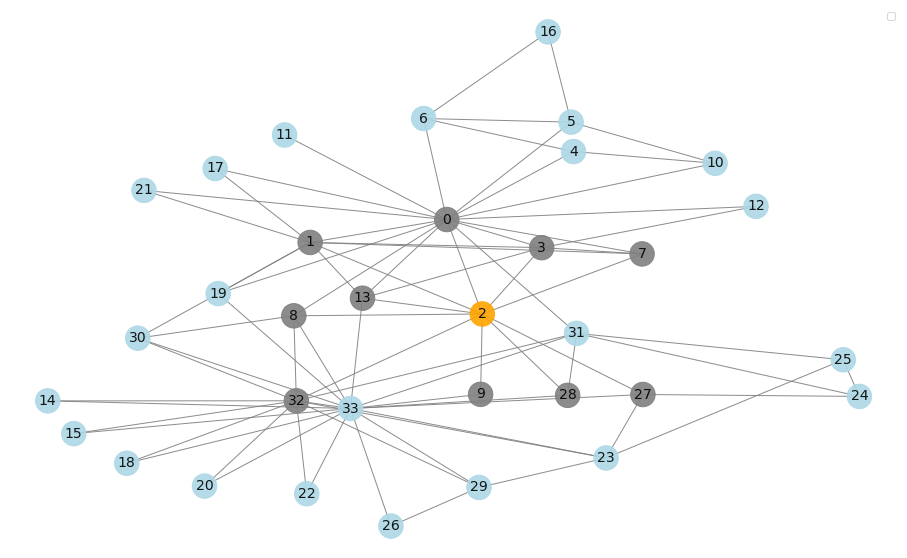

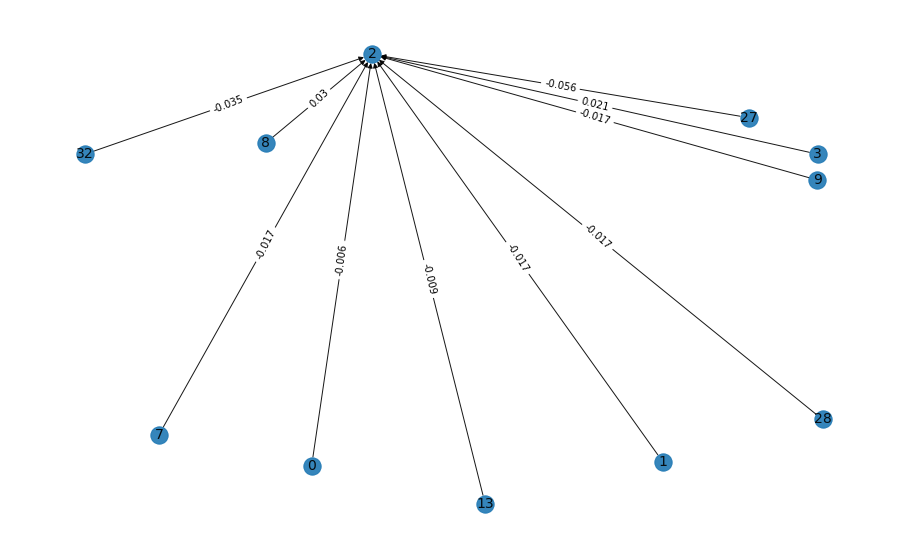

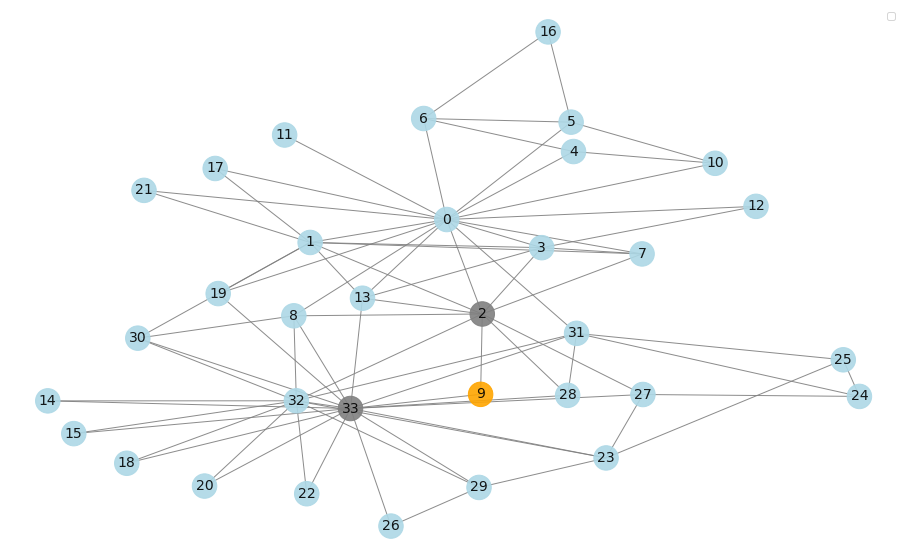

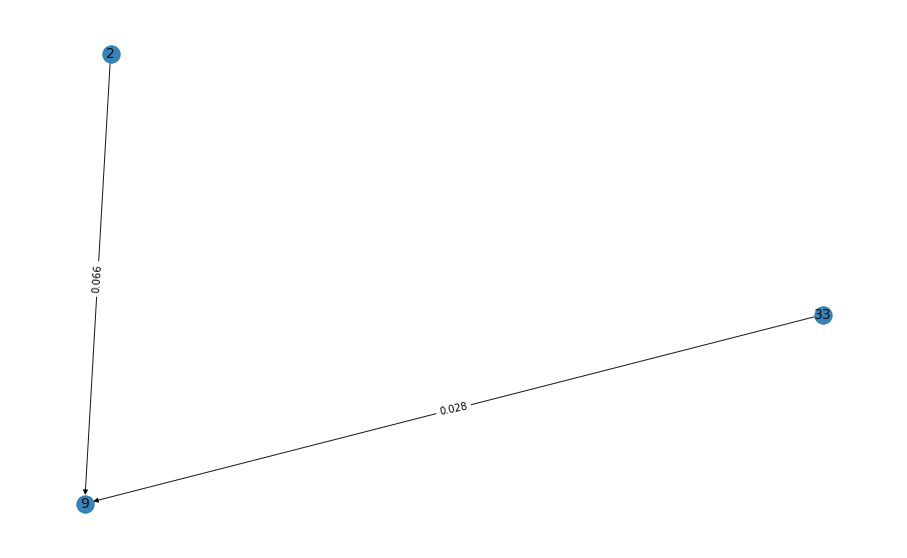

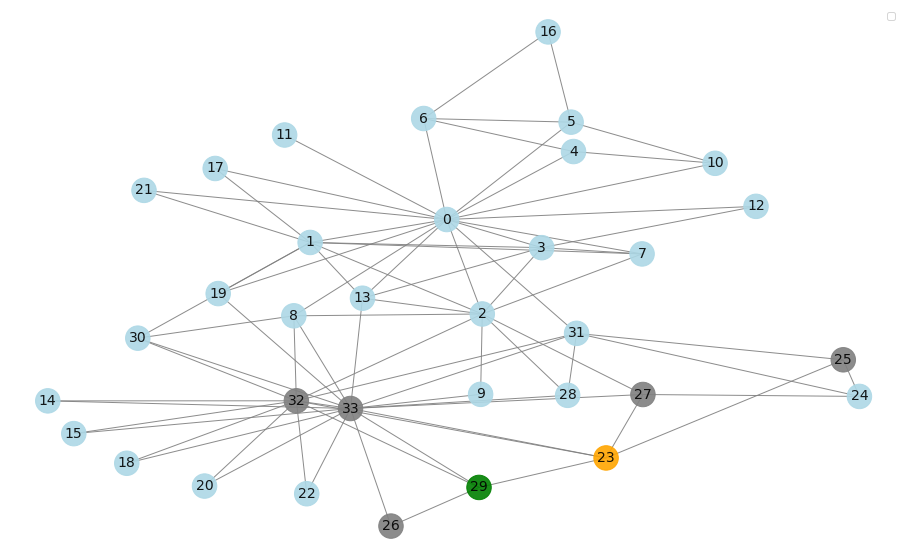

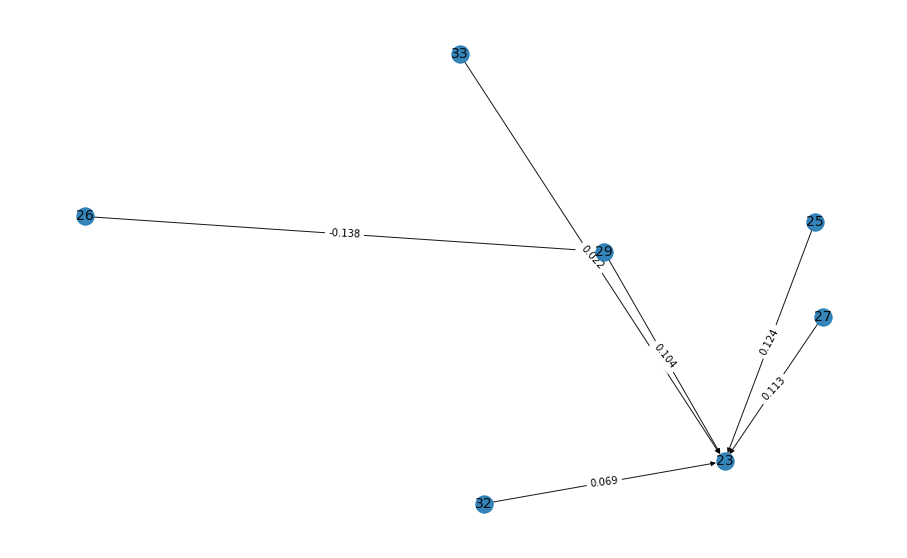

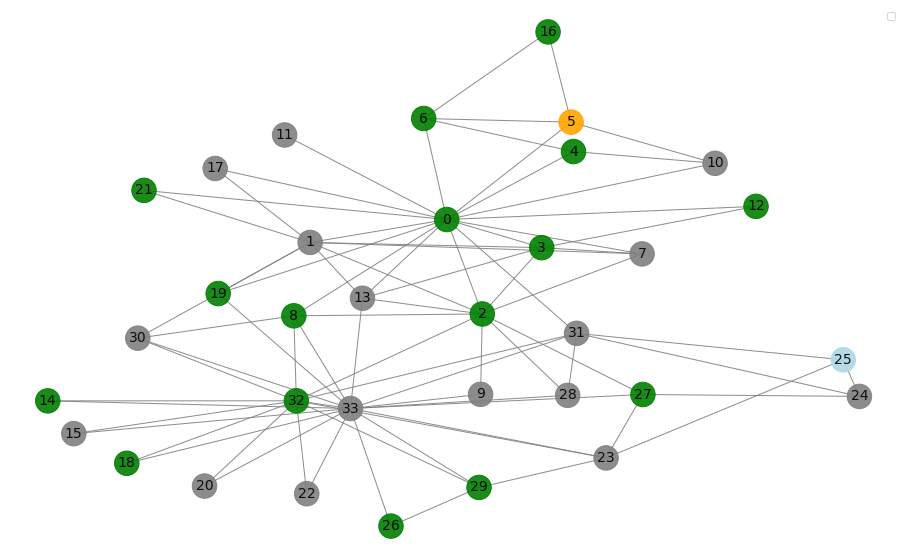

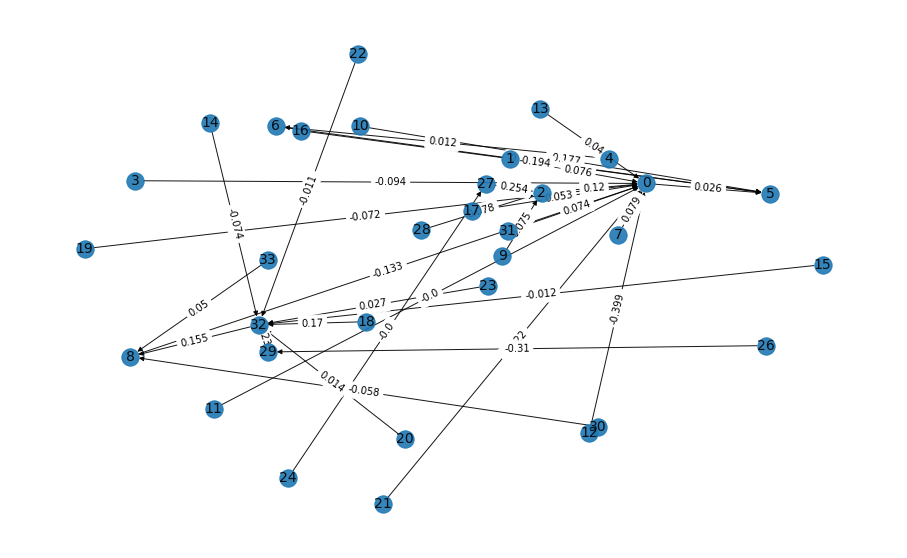

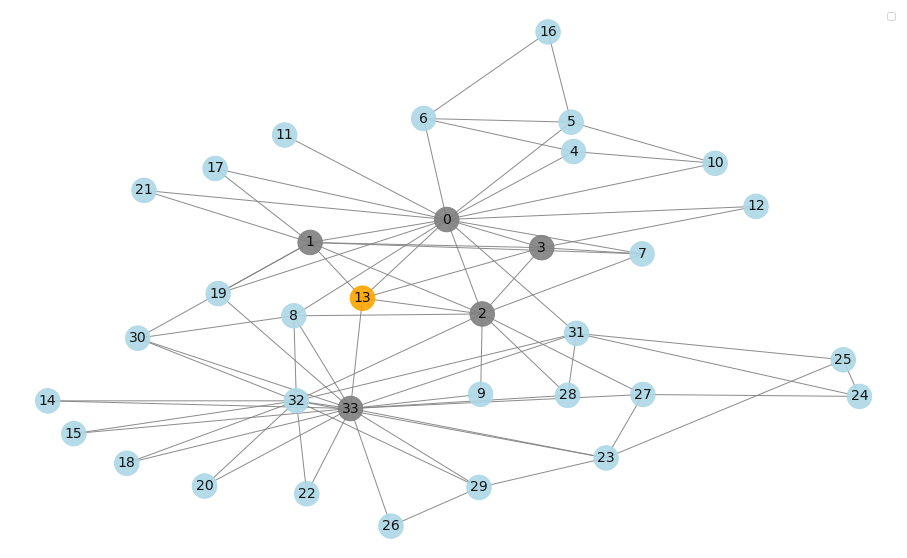

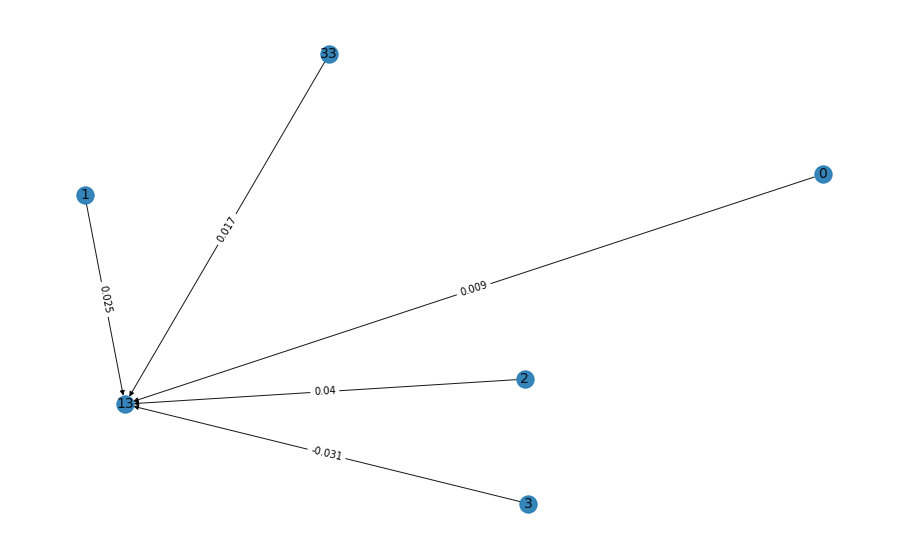

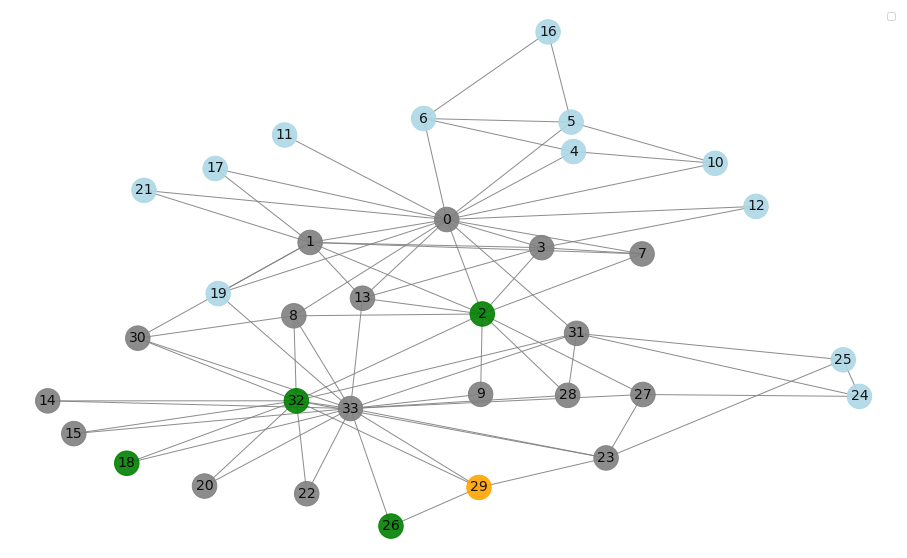

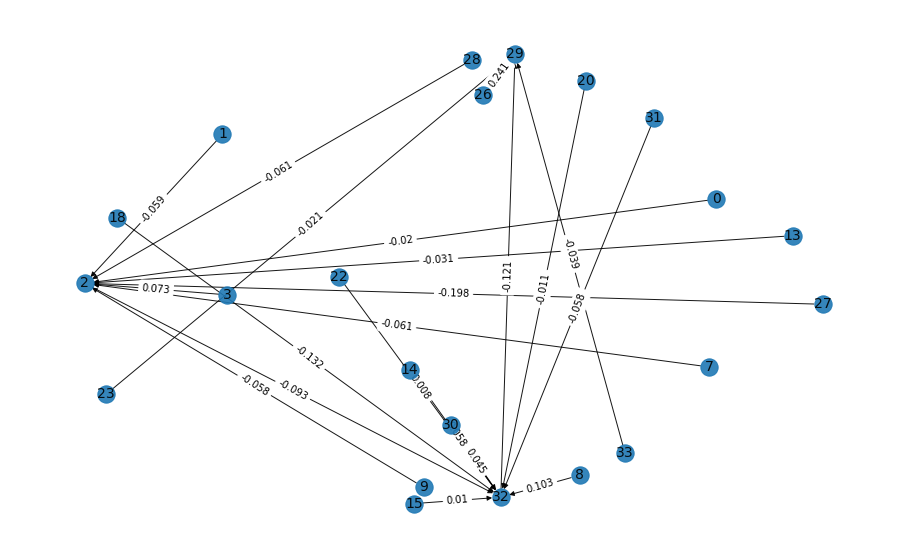

In [31]:
#### def run_simulation(post, steps):

    model = NetworkInfectionModel(post)
    for i in range(steps):

        model.step(i)
        #agent_state = model.datacollector.get_agent_vars_dataframe()
        #X = pd.pivot_table(agent_state.reset_index(), index='Step', columns='State', aggfunc=np.size, fill_value=0)  
        
    #print(model.datacollector.get_agent_vars_dataframe())
    agent_state = model.datacollector.get_agent_vars_dataframe()
    
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    agents = model.agents
    
    return model, states, agents, model.G, model.G_share, agent_state
    #plot_graph(model.G_share)
#X = pd.pivot_table(agent_state.reset_index(), index='Step', columns='State', aggfunc=np.size, fill_value=0)


steps=50
SimModel, states, agents, AgentGraphs, SancGraphs, AgentStates, runtime = {}, [], [], [], [], [], []

for j, pc in enumerate(post_conf):

    st=time.time()
    
    post = Post
    post['author'] = pc[0]
    post['party_mentioned'] = pc[1]
    post['stance'] = pc[2]
    
    SimModel[j], state, agent, G_agents, G_sanctions, agent_state = run_simulation(post, steps)
    et = time.time()
    rt = round(et-st, 5)
    
    #SimModel[j] = Sim_model
    states.append(state) 
    agents.append(agent)
    AgentGraphs.append(G_agents)
    SancGraphs.append(G_sanctions)
    AgentStates.append(agent_state)
    runtime.append(rt)
    
    #Visualization().plot_sim_network(SimModel[1])
    #time.sleep(1)
    Visualization().plot_sim_network(G_agents, state)
    Visualization().plot_sanction_graph(G_sanctions)
    
    print("\nSimulaton run ", j, "completed. \nTime taken to run the simulation ", rt, " sec")
    
final_sanc_graph = Visualization().aggregate_sanction_graphs(SancGraphs)
G_sharing = Visualization().get_sharing_graphs(G, final_sanc_graph)    

In [21]:
new_user_pol = []
nodes = list(G.nodes())
for nd in nodes:
    d = data.iloc[nd]
    user_pol = d['user_inclination']
    ch = 0
    print(nd)
    edges = [x for x in final_sanc_graph.in_edges(nd) if nd in final_sanc_graph.nodes()]
    for ed in edges:
        usp2 = data.iloc[ed[0]]['user_inclination']
        wt = final_sanc_graph[ed[0]][ed[1]]['weight']
        ch += (user_pol * usp2 * wt)
        
    #print(round(ch, 3))
    new_usp = round(user_pol + user_pol * ch, 3)
    if(new_usp > 1.0):
        new_usp = 1
    elif(new_usp < -1):
        new_usp = -1
    
    new_user_pol.append(new_usp)

data['updated_pol'] = new_user_pol

0
1
2
3
4
5
6
7
8
9
10
11


NetworkXError: nbunch is not a node or a sequence of nodes.

/home/ahaque2/venv/py3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ahaque2/venv/py3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


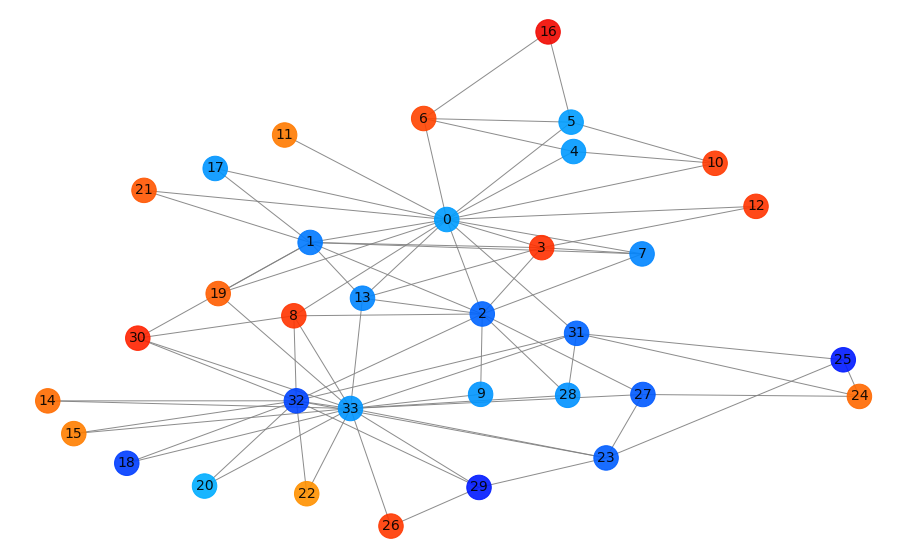

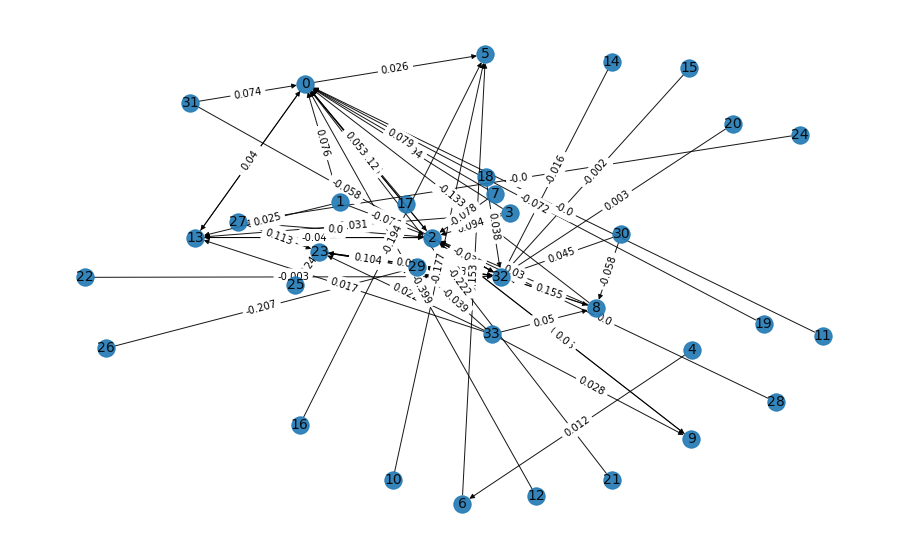

In [32]:
color_map = Visualization().add_pol_polarity_score(data, 'user_inclination')
Visualization().plot_pol_network(G_sharing, color_map)
Visualization().plot_sanction_graph(final_sanc_graph)

#color_map = Visualization().add_pol_polarity_score(data, 'updated_pol')
#Visualization().plot_pol_network(G_sharing, color_map)

In [ ]:
# Visualization().plot_sim_network(AgentGraphs[0], states[0])
# Visualization().plot_sanction_graph(SancGraphs[0])

In [ ]:
#agent_state = AgentStates[1]
#AgentStates[0].loc[19,]
#pd.pivot_table(AgentStates[0].reset_index(), index='Step', columns='State', aggfunc=np.size, fill_value=0)

In [ ]:
data.columns

In [33]:
data

,id,gender,age,education,income,user_activity,user_interest,privacy_preference,user_inclination,ppol
0,0,0,0,2,0,0.937,0.238,0.572,0.128,0.2808
1,1,1,0,0,0,1.000,0.221,0.242,0.384,0.2424
2,2,0,0,2,0,0.533,0.509,1.000,0.490,0.2265
3,3,1,1,0,2,0.502,0.296,0.674,-0.704,0.8556
4,4,0,1,0,1,0.265,0.318,0.547,0.164,0.2754
5,5,1,1,0,2,0.783,0.285,0.425,0.138,0.2793
6,6,1,1,1,1,1.000,0.289,0.248,-0.588,0.8382
7,7,1,1,1,0,0.729,0.402,0.094,0.298,0.2553
8,8,0,0,1,0,0.631,0.333,0.650,-0.702,0.8553
9,9,1,1,0,0,0.811,0.518,0.333,0.198,0.2703


In [ ]:
[x for x in final_sanc_graph.in_edges(data=True)]

In [ ]:
[n for n in final_sanc_graph.neighbors(0)]

In [ ]:
# from timeit import default_timer as timer
# from numba import jit
# import math

# #@jit
# def hypot(x, y):
#     # Implementation from https://en.wikipedia.org/wiki/Hypot
#     x = abs(x);
#     y = abs(y);
#     t = min(x, y);
#     x = max(x, y);
#     t = t / x;
#     return x * math.sqrt(1+t*t)
# hypot = jit(hypot)

# timeit hypot.py_func(3.0, 4.0)
# timeit hypot(3.0, 4.0)

# start = timer()
# hypot.py_func(3,4)
# print("without GPU:", round((timer()-start) * 1000, 3)) 

# #hypot = jit(hypot)
# start = timer()
# hypot(3,4)
# print("with GPU:", round((timer()-start) * 1000, 3))   